# Lecture 06 Algorithms for Linear Algebra

This notebook is to demonstrate the convergence properties of different iterative linear solvers! Before starting, make sure that the necessary python packages are installed. Most solvers used in this demo are from the sparse linear algebra packages supplied by scipy in python.

In [ ]:
# !pip3 install --user matplotlib;
# !pip3 install --user krypy;
# !pip3 install --user pyamg;

Now let's start by loading the packages.

In [2]:
from matplotlib import pyplot, animation, rc
import matplotlib as mpl
from cycler import cycler

import numpy as np
import nelin
import pyamg
import time
import matplotlib.pyplot as plt
from pyamg.aggregation import smoothed_aggregation_solver
mpl.style.use('classic')
# use latex in matplotlib

# get colors
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')## Problem Decription
colors=mpl.rcParams['axes.prop_cycle'] .by_key()['color']


## Problem Decription

Two problems are used here:

1. First is a poisson problem written as:

$$-\nabla^2 u=g$$

For 1D case, the dicretization is:
$$-\frac{1}{h^2}(u_{i-1}-2u_{i}+1u_{i+1})=g$$

For the 2D case, the dicretization is
$$
-\frac{u_{i+1,y}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}-4u_i}{h^2}=g
$$

2. The second is a steady-state advection-diffusion problem problem written as:
$$u_x+vu_{xx}=0$$

For discretization, we introduction both a second-order finite difference approximation for the first-derivative and second-derivatives like:
$$\frac{du}{dx}|_{x=x_i}=\frac{1}{2h}(-3u_i+4u_{i+1}+3u_{i+2})$$
$$\frac{d^2u}{dx^2}|_{x=x_i}=\frac{1}{h^2}(u_{i-1}-2u_{i}+u_{i+1})$$



All of these problems can be written as a linear system in the form as
$$\bf{A}\bf{u}=\bf{b}$$


We will show the iterative performance for the following solvers:

Basic iterative solver:
1. Jacobi Iteration (JI)
2. Gauss-Siedel Iteration (GS)

Advanced iterative solver (Krylov Solver & Mulitigrid Solver)
1. Conjugate Gradient (CG)
2. Generalized Minimal Residual Method (GMRES)
3. Biconjugate Gradient Stabilized Method (BiCGstab)
4. Algebric Multigrid Method (AMG)
 

## Common Iterative Smoother
### 1D Poisson Problem

To start with, let's start on the 1D poisson problem, thanks to the other developer, we can easily construct the linear system for 1D poisson problem by:

In [3]:
n = 100
A = pyamg.gallery.poisson((n,), format='csr')

/home/matt/miniconda3/envs/py36/lib/python3.6/site-packages/pyamg/gallery/stencil.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
/home/matt/miniconda3/envs/py36/lib/python3.6/site-packages/pyamg/gallery/stencil.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0


In [4]:
#You can examine the matrix structure here
print(A[1,:])
# print(A)

  (0, 0)	-1.0
  (0, 1)	2.0
  (0, 2)	-1.0


The linear operator constructed is stored in compress sparse row format. To show convergence of each solver, we set final solution to be $0$, we can see $\bf{b}$ is also zero. Then the solution of each iterative step is the also the intermediate error.

For the initial guess of solution, though traditionally we alway use $b$, here we use a random solution vector. Otherwise the solvers will converge to 0 very fast. 

In [5]:
x_0 = np.sin(np.arange(0,n)/100.0*np.pi*1.0) + np.sin(np.arange(0,n)/100.0*np.pi*6.0)

refx = np.zeros(A.shape[0])
b=A.dot(np.array(refx))
nSize=A.shape[0]

print(nSize)
print(x_0)

100
[ 0.00000000e+00  2.18792074e-01  4.30915072e-01  6.29935108e-01
  8.09880339e-01  9.65451459e-01  1.09220837e+00  1.18672640e+00
  1.24671662e+00  1.27110581e+00  1.26007351e+00  1.21504460e+00
  1.13863780e+00  1.03457188e+00  9.07532966e-01  7.63007494e-01
  6.07086908e-01  4.46250896e-01  2.87136908e-01  1.36304086e-01
  1.11022302e-16 -1.16061574e-01 -2.06903936e-01 -2.68464621e-01
 -2.97740145e-01 -2.92893219e-01 -2.53318623e-01 -1.79665416e-01
 -7.38146827e-02  6.11863850e-02  2.21231742e-01  4.01301283e-01
  5.95638038e-01  7.97951507e-01  1.00163991e+00  1.20002352e+00
  1.38658073e+00  1.55517862e+00  1.70028973e+00  1.81718745e+00
  1.90211303e+00  1.95240839e+00  1.96660989e+00  1.94449992e+00
  1.88711430e+00  1.79670533e+00  1.67666181e+00  1.53138876e+00
  1.36615128e+00  1.18688787e+00  1.00000000e+00  8.12125246e-01
  6.29902176e-01  4.59735170e-01  3.07567595e-01  1.78671346e-01
  7.74601983e-02  7.33360081e-03 -2.94435673e-02 -3.18210156e-02
 -1.11022302e-16  6.4

interactive(children=(IntSlider(value=0, description='w', max=1000, step=50), Output()), _dom_classes=('widget…

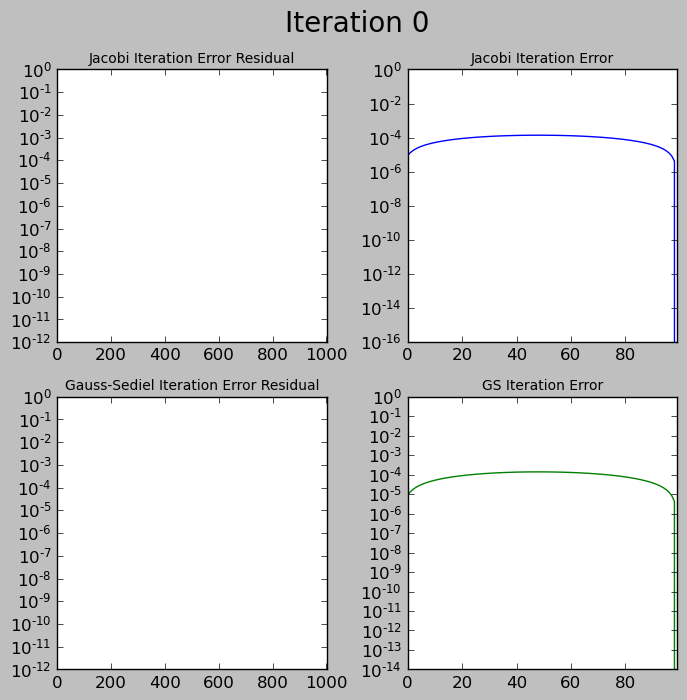

In [8]:
# %matplotlib notebook
from ipywidgets import *
import numpy as np
import IPython
import scipy
import matplotlib
matplotlib.use('tkAgg')
import matplotlib.pyplot as plt

# from IPython.display import clear_output

nSize=A.shape[0]

jac_sol = nelin.solutionvector(nSize,x_0)
x_jac=  nelin.Jac(A,b,x0=x_0, tol=1e-9,maxiter=1000,callback=jac_sol.store)
resv_jac,resnorm_jac=jac_sol.getres(A,b)
 


gs_sol = nelin.solutionvector(nSize,x_0)

x_gs =  nelin.GS(A,b,x0=x_0, tol=1e-9,maxiter=1000,w=1,callback=gs_sol.store)
resv_gs,resnorm_gs=gs_sol.getres(A,b)

jaciter,jacsol=jac_sol.getsol()
gsiter,gssol=jac_sol.getsol()



# Create Sub plots
fig,axs = plt.subplots(2, 2,figsize=(1600./200,1500./200), dpi=100)
fig.subplots_adjust(wspace=0.3)
axs[0][0].set_title('Jacobi Iteration Error Residual', fontsize=10)
axs[1][0].set_title('Gauss-Sediel Iteration Error Residual', fontsize=10)
axs[0][0].set_yscale('log')
axs[1][0].set_yscale('log')
axs[0][1].set_title('Jacobi Iteration Error', fontsize=10)
axs[1][1].set_title('GS Iteration Error', fontsize=10)
axs[0][1].set_yscale('log')
axs[1][1].set_yscale('log')
axs[0][0].set_xlim(0,jaciter)
axs[1][0].set_xlim(0,gsiter)
axs[0][0].set_ylim(1e-12,1)
axs[1][0].set_ylim(1e-12,1)
axs[0][1].set_xlim(0,nSize-1)
axs[1][1].set_xlim(0,nSize-1)
axs[0][1].set_ylim(1e-16,1)
axs[1][1].set_ylim(1e-14,1)

# animation function.  This is called sequentially
jacplot,= axs[0][0].plot([], [], color=colors[0])
gsplot,= axs[1][0].plot([], [], color=colors[1])
jacplote,= axs[0][1].plot([], [], color=colors[0])
gsplote,= axs[1][1].plot([], [], color=colors[1])


def update(w=40):
    ijac=w;
    igs=w;

    print('Start')
    if(w>=jaciter):
        ijac=jaciter-1
    if(w>=gsiter):
        igs=gsiter-1


    jacplot.set_data(np.arange(0, ijac+1), resnorm_jac[:ijac+1])
    gsplot.set_data(np.arange(0, igs+1), resnorm_gs[:igs+1])
   
    jacplote.set_data(np.arange(0, nSize), np.abs(resv_jac[ijac,:]))
    gsplote.set_data(np.arange(0, nSize), np.abs(resv_gs[igs,:]))

    fig.suptitle('Iteration {}'.format(w), fontsize=20)
    fig.canvas.draw()

interact(update,w=IntSlider(value=0,min=0,max=1000,step=50));
#                 jacplot=fixed(jacplot),gsplot=fixed(gsplot),
#                 jacplote=fixed(jacplote),gsplote=fixed(gsplote));
# If you cannot use iteractive mode us uncomment the nextwo lines    
# ani = animation.FuncAnimation(fig, update, repeat_delay=50,interval=50,repeat=False,frames=len(resnorm_gs)-1, blit=True)
# plt.show();



# interact(update);

## Advanced Iterative Solver

### 1D Poisson Problem

In [ ]:
pyamg.gallery.poisson((2000,), format='csr')
refx = np.random.rand(A.shape[0])
b=A.dot(np.array(refx))
nSize=A.shape[0]
nelin.PrintCompare(A,x_0,b,refx,M=None)

### What do you observe?
1. Accuray?
2. Speed?
3. Iteration Number?

Now we increase the size of the matrix.

In [ ]:
A1 = pyamg.gallery.poisson((2000,), format='csr')
b1 = np.zeros(A1.shape[0])
x_1 = np.random.randn(A1.shape[0])
refx1 = np.ones(A1.shape[0])
b1=A1.dot(np.array(refx1))
nSize=A1.shape[0]
# Case without Preconditioner
nelin.PrintCompare(A1,x_1,b1,refx1,M=None)

### What do you observe?
1. Accuray?
2. Speed?
3. Iteration Number?
4. Comparing with small size problem?

Now we see what happened if we use some preconditioner matrix.

In [ ]:
print('For Small Size Problem:')
ml = smoothed_aggregation_solver(A)  
M = ml.aspreconditioner(cycle='V') 
nelin.PrintCompare(A,x_0,b,refx,M)


print('For Large Size Problem:')
ml1 = smoothed_aggregation_solver(A1)  
M1 = ml1.aspreconditioner(cycle='V') 
nelin.PrintCompare(A1,x_1,b1,refx1,M1)

### What do you observe?
1. Accuray?
2. Speed?
3. Iteration Number?
4. Compare with the unpreconditioned case?

### 2D Poisson Problem
Now let's look at 2D poisson problem.

In [ ]:
B = pyamg.gallery.poisson((100,100), format='csr')
b = np.zeros(B.shape[0])
x_0 = np.random.randn(B.shape[0])
refx = np.ones(B.shape[0])
b=B.dot(np.array(refx))
nSize=B.shape[0]

* Unpreconditioned Case

In [ ]:
nelin.PrintCompare(B,x_0,b,refx,M=None)

* Preconditioned Case

In [ ]:
ml = smoothed_aggregation_solver(B)  
M = ml.aspreconditioner(cycle='V') 
nelin.PrintCompare(B,x_0,b,refx,M)

### 1D Advection-diffusion problem
Now let's look at 2D poisson problem.

In [ ]:
# This is a advection-convection problem
v=-0.02;
N=1000;
grid=N
h=1.0/N;
s_ad=1/2.0/h*np.array([0,-3,4,-1]);
s_diff=v/(h**2.0)*np.array([1,-2,1,0]);
grid=N;
A=nelin.stencil_grid_1d(s_ad+s_diff,grid,np.array([-1,0,1,2]),format='csr');
refx = np.ones(A.shape[0])
b=A.dot(np.array(refx))

x_0 = b;

In [ ]:
nelin.PrintCompare(A,x_0,b,refx,M=None)

### What do you observe?
1. Accuray?
2. Speed?
3. Iteration Number?
4. Why CG failed?
5. Why AMG error becomes significantly larger

## Error Plot

In [ ]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import IPython
import matplotlib.pyplot as plt
import scipy
from IPython.display import clear_output
A = pyamg.gallery.poisson((100,), format='csr')
b = np.zeros(A.shape[0])
x_0 = np.sin(np.arange(0,100)/100*np.pi)*2
refx = np.ones(A.shape[0])
b=A.dot(np.array(refx))
nSize=A.shape[0]

cg_sol = nelin.solutionvector(nSize,x_0)
x_cg,info =  scipy.sparse.linalg.cg(A,b,x0=x_0, tol=1e-10,M=None,callback=cg_sol.store)
resv_cg,resnorm_cg=cg_sol.getres(A,b)
 


bicg_sol = nelin.solutionvector(nSize,x_0)

x_bicg,info =  scipy.sparse.linalg.bicgstab(A,b,x0=x_0, tol=1e-10,M=None,callback=bicg_sol.store)
resv_bicg,resnorm_bicg=bicg_sol.getres(A,b)

ml = smoothed_aggregation_solver(A) 
M = ml.aspreconditioner(cycle='V') 
amg_sol= nelin.solutionvector(nSize,x_0)    
x_amg=ml.solve(b=b,x0=x_0,tol=1e-10,callback=amg_sol.store,accel='cg')
resv_amg,resnorm_amg=amg_sol.getres(A,b)



cgiter,cgsol=cg_sol.getsol()
bicgiter,bicgsol=bicg_sol.getsol()
amgiter,amgsol=amg_sol.getsol()




fig,axs = plt.subplots(3, 2,figsize=(1600./200,1500./200), dpi=100)
fig.subplots_adjust(wspace=0.3)
axs[0][0].set_title('CG Iteration Error Residual', fontsize=10)
axs[1][0].set_title('BiCG Iteration Error Residual', fontsize=10)
axs[2][0].set_title('AMG Iteration Error Residual', fontsize=10)
axs[0][0].set_yscale('log')
axs[1][0].set_yscale('log')
axs[2][0].set_yscale('log')
axs[0][1].set_title('CG Iteration Error', fontsize=10)
axs[1][1].set_title('BiCG Iteration Error', fontsize=10)
axs[2][1].set_title('AMG Iteration Error', fontsize=10)
axs[0][1].set_yscale('log')
axs[1][1].set_yscale('log')
axs[2][1].set_yscale('log')

axs[0][0].set_xlim(0,cgiter)
axs[1][0].set_xlim(0,bicgiter)
axs[2][0].set_xlim(0,amgiter)
axs[0][0].set_ylim(1e-12,1)
axs[1][0].set_ylim(1e-12,1)
axs[2][0].set_ylim(1e-12,1)
axs[0][1].set_xlim(0,nSize)
axs[1][1].set_xlim(0,nSize)
axs[2][1].set_xlim(0,nSize)
axs[0][1].set_ylim(1e-16,1)
axs[1][1].set_ylim(1e-14,1)
axs[2][1].set_ylim(1e-14,1)
# animation function.  This is called sequentially

cgplot,= axs[0][0].plot([], [], color=colors[0])
bicgplot,= axs[1][0].plot([], [], color=colors[1])
amgplot,= axs[2][0].plot([], [], color=colors[2])

cgplote,= axs[0][1].plot([], [], color=colors[0])
bicgplote,= axs[1][1].plot([], [], color=colors[1])
amgplote,= axs[2][1].plot([], [], color=colors[2])

def update(w=40):
    icg=w;
    ibicg=w;
    iamg=w;
    print('Start')
    if(w>=cgiter):
        icg=cgiter-1
    if(w>=bicgiter):
        ibicg=bicgiter-1
    if(w>=amgiter):
        iamg=amgiter-1

    cgplot.set_data(np.arange(0, icg+1), resnorm_cg[:icg+1])
    bicgplot.set_data(np.arange(0, ibicg+1), resnorm_bicg[:ibicg+1])
    amgplot.set_data(np.arange(0, iamg+1), resnorm_amg[:iamg+1])    
    cgplote.set_data(np.arange(0, nSize), np.abs(resv_cg[icg,:]))
    bicgplote.set_data(np.arange(0, nSize), np.abs(resv_bicg[ibicg,:]))
    amgplote.set_data(np.arange(0, nSize), np.abs(resv_amg[iamg,:]))
    fig.suptitle('Iteration {}'.format(w), fontsize=20)
    fig.canvas.draw_idle()

interact(update,w=IntSlider(value=0,min=0,max=100,step=1));
# If you cannot use iteractive mode us uncomment the nextwo lines    
# ani = animation.FuncAnimation(fig, update, repeat_delay=50,interval=50,repeat=False,frames=len(resnorm_bicg)-1, blit=True)
# plt.show()



# interact(update)

## GMRES: Convergence vs Ritz Value

In [ ]:
# This is a advection-convection problem
v=-0.02;
N=100;
n=N
grid=N
h=1.0/N;
s_ad=1/2.0/h*np.array([0,-3,4,-1]);
s_diff=v/(h**2.0)*np.array([1,-2,1,0]);
grid=N;
A=nelin.stencil_grid_1d(s_ad+s_diff,grid,np.array([-1,0,1,2]),format='csr');
refx = np.ones(A.shape[0])
b=A.dot(np.array(refx))

b = refx+np.random.rand(A.shape[0])*0.01;

In [ ]:
# Calculation the eigenvalue
evals = np.linalg.eigvals(np.array(A.todense()))

In [ ]:
# pyplot.figure()
# pyplot.plot(evals.real, evals.imag, 'x', color=colors[1], alpha=0.5)
# pyplot.xscale('log')
# pyplot.xscale('log')
# pyplot.title('roots of GMRES polynomial')
# pyplot.xlabel('Real part')
# pyplot.ylabel('Imaginary part')


In [ ]:
import krypy
import numpy as np
b=b;
ls = krypy.linsys.LinearSystem(A, b, Ml=None)
solver = krypy.linsys.Gmres(ls, tol=1e-9, store_arnoldi=True)

H = solver.H

def get_gmres_roots(H):
    n_, n = H.shape

    from scipy.linalg import eig
    theta, _ = eig(H[:n, :])
    return theta

In [ ]:
%matplotlib notebook
nSize=A.shape[0]
fig, axs = pyplot.subplots(ncols=2, figsize=(1920./200,1080./200), dpi=100)
fig.subplots_adjust(wspace=0.3)
line_res, = axs[0].plot([], [])
line_roots, = axs[1].plot([], [], '.', color=colors[0])
all_roots = np.concatenate(
    [evals] + [get_gmres_roots(H[:i+1, :i]) for i in range(1, n+1)]
    )
axs[0].set_yscale('log')
axs[0].set_xlim(0, n)
axs[0].set_ylim(np.min(solver.resnorms), np.max(solver.resnorms))
axs[0].set_title('GMRES residual norm')
axs[0].set_xlabel('GMRES iteration')
axs[0].set_ylabel(r'$\frac{\|r_i\|}{\|b\|}$')
axs[1].plot(evals.real, evals.imag, 'x', color=colors[1], alpha=0.5)
axs[1].set_xlim(0.95*np.min(all_roots.real), 1.05*np.max(all_roots.real))
axs[1].set_ylim(1.05*np.min(all_roots.imag), 1.05*np.max(all_roots.imag))
axs[0].set_yscale('log')
axs[0].set_xlim(0, n)
axs[1].set_xscale('log')
def update(w):
    if w <-1:
        w=1
    if w > nSize:
        w=nSize
    line_res.set_data(list(range(0, w+1)), solver.resnorms[:w+1])
    print(w)
    roots = get_gmres_roots(H[:w+1, :w])
    line_roots.set_data(roots.real, roots.imag)
    fig.canvas.draw_idle()


# interact(update,w=IntSlider(value=0,min=1,max=100,step=1));
interact(update,w=IntSlider(value=1,min=1,max=100,step=1));
# If you cannot use iteractive mode us uncomment the nextwo lines    
# ani = animation.FuncAnimation(fig, update,np.arange(1,101),repeat=False,interval=50)
# plt.show()

In [ ]:
import os,sys,glob
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
n = 4
m = 3
p = 2
INTS=[0,10]

inputs = ['x%d'%i for i in range(m)]
outputs = ['y%d'%i for i in range(p)]

X = np.random.randint(*INTS,(n,m))
y = np.random.randint(*INTS,(n,p))
data = np.concatenate([X,y],axis=1)
columns = inputs+outputs

df = pd.DataFrame(data=data,columns=columns)

In [ ]:
round()

In [ ]:
cwd=''
directory=''
file='test.csv'
path=os.path.join(cwd,directory,file)
globdir = glob.glob(directory)
print(path,globdir)

In [ ]:
print(df)

In [ ]:
a = {1:[1,2,3]}
b = {**{1:99},**a}
print(b)